Alunos:

* Marcos César Madruga Alves Pinheiro (mcmap@cesar.school)

* Maria Paula Martins Alves (mpma@cesar.school)

* Ricardo Jorge Rezende de Mello Filho ( rjrmf@cesar.school )

## Importação das bibliotecas

In [ ]:
# http://pytorch.org/
from os.path import exists

import torch

In [ ]:
#Importar bibliotecas

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import Dataset, random_split
from torch.optim.lr_scheduler import StepLR
from PIL import UnidentifiedImageError
from tqdm import tqdm  # Barra de progresso (opcional, mas útil)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import torch.nn.init as init

# Importação dos Dados

https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data

Os dados foram obtidos do link acima.


Um tumor cerebral é considerado uma das doenças agressivas, tanto em crianças quanto em adultos. Os tumores cerebrais representam de 85 a 90 por cento de todos os tumores primários do Sistema Nervoso Central (SNC). Todos os anos, cerca de 11.700 pessoas são diagnosticadas com um tumor cerebral. A taxa de sobrevivência em 5 anos para pessoas com um tumor cancerígeno no cérebro ou no SNC é de aproximadamente 34% para homens e 36% para mulheres. Os Tumores Cerebrais são classificados como: Tumor Benigno, Tumor Maligno, Tumor Hipofisário, etc. Tratamento adequado, planejamento e diagnósticos precisos devem ser implementados para melhorar a expectativa de vida dos pacientes. A melhor técnica para detectar tumores cerebrais é a Ressonância Magnética (RM). Uma enorme quantidade de dados de imagem é gerada através das tomografias. Essas imagens são examinadas pelo radiologista. Um exame manual pode ser propenso a erros devido ao nível de complexidade envolvido nos tumores cerebrais e suas propriedades.

A aplicação de técnicas de classificação automatizada usando Machine Learning (ML) e Inteligência Artificial (IA) tem mostrado consistentemente maior precisão do que a classificação manual. Portanto, propor um sistema que realize detecção e classificação utilizando Algoritmos de Aprendizado Profundo com Rede Neural Convolucional (CNN), Rede Neural Artificial (ANN) e Aprendizado por Transferência (TL) seria útil para médicos em todo o mundo.

In [ ]:
#!/bin/bash
!curl -L -o /content/brain-tumor-classification-mri.zip   https://www.kaggle.com/api/v1/datasets/download/sartajbhuvaji/brain-tumor-classification-mri

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 86.7M  100 86.7M    0     0  79.0M      0  0:00:01  0:00:01 --:--:--  153M


In [ ]:
!unzip -q -o /content/brain-tumor-classification-mri.zip -d /content/brain-tumor-classification-mri


In [ ]:
#Criação das pastas

brain_tumor_folder_train = "/content/brain-tumor-classification-mri/Training"
# brain_tumor_folder_test = "/content/brain-tumor-classification-mri/Testing"

#Metodologia do Projeto

**Objetivo do Projeto**: Treinar o modelo para realizar a classificação correta das imagens da ressonância magnética

**Metodologia utilizada**


* Os Dados originais foram divididos em 2 datasets (Treino e Teste - 70% Treino e 30% Teste)
* Foram realizadas transformações nas imagens para serem usadas como entradas da rede (redimensionalização, transformação para escala de cinza)
* Foram criados data_loaders para dividir os dados em mini_batch e aprimorar o treinamento do modelo
* Foi criada uma rede neural para realizar a classificação das imagens usando hidden layers e função de ativação Relu
* A rede foi treinada com os dados de treino e testadas com os dados de teste.
* A avaliação foi feita com base na eficácia do modelo para os dois cenários (Treino e Teste)
* Durante o treinamento foram testados e avaliados diferentes parâmetros de learning rate (utilizando ajustes dinâmicos com StepLR), batch_size, optimizers.
* A solução apresentada nesse projeto é a combinação dos parâmetros que apresentou bons resultados em teste e treino sem overfitting ou underfitting



#Criação de Datasets de Treino e Teste

In [ ]:
#Transform a ser aplicados nas imagens originais

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p= 0.5),
    transforms.Normalize(mean=[0.5],std=[0.5])

])



In [ ]:
#Subclasse personalizada para avaliar dificuldade em abrir alguma imagem

class Dataset(datasets.ImageFolder):
  def __getitem__(self, index):
    try:
      return super(Dataset, self).__getitem__(index)
    except UnidentifiedImageError:
      print(f"Pulou Imagem problematica no indice {index}")
      return None

In [ ]:
# dataset_test = Dataset(brain_tumor_folder_test,transform)
# dataset_train = Dataset(brain_tumor_folder_train, transform)

In [ ]:
#Criação do Dataset e sua divisão em treino e teste (70/30)

dataset = Dataset(brain_tumor_folder_train, transform)
dataset_train, dataset_test = random_split(dataset, [0.7, 0.3])

In [ ]:
#Comprimento dos dados de treino
len(dataset_train)

2009

In [ ]:
#Comprimento dos dados de teste
len(dataset_test)

861

In [ ]:
#Classes do dateset
dataset_train.dataset.classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

#Criação e Avaliação do Modelo

## Criação da rede

In [ ]:
input_size = 128*128
output_size = 4
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net()

In [ ]:
# # Inicializando os pesos das camadas lineares com a técnica He
# for m in model.modules():
#     if isinstance(m, nn.Linear):
#         init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)

In [ ]:
#Estrutura da Rede Neural

model


Net(
  (fc): Sequential(
    (0): Linear(in_features=16384, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=2048, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2048, out_features=4096, bias=True)
    (11): ReLU()
    (12): Linear(in_features=4096, out_features=2048, bias=True)
    (13): ReLU()
    (14): Linear(in_features=2048, out_features=1024, bias=True)
    (15): ReLU()
    (16): Linear(in_features=1024, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512, out_features=256, bias=True)
    (19): ReLU()
    (20): Linear(in_features=256, out_features=128, bias=True)
    (21): ReLU()
    (22): Linear(in_features=128, out_features=4, bias=True)
  )
)

## Treinamento

In [ ]:
model = Net()

In [ ]:
#Predição de um valor específico do treino
model(dataset_train[10][0])



tensor([[-1.3795, -1.4403, -1.3062, -1.4247]], grad_fn=<LogSoftmaxBackward0>)

### Criando os objetos de treinamento e teste

In [ ]:
#log_interval: Um número inteiro que especifica a cada quantos lotes (batches) a informação sobre o progresso do treinamento deve ser impressa (perda, porcentagem concluída, etc.).
#dry_run: Um valor booleano. Se for True, a função executará apenas um lote de treinamento e depois parará. Isso é útil para verificar se o código básico de treinamento está funcionando sem ter que esperar que uma época inteira termine

def train(log_interval, dry_run, model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        # correct = 0 # Madruga
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() #Zera os gradientes
        output = model(data) #Roda o modelo para prever os dados
        loss = criterion(output, target) #Cálcula a função de perda
        loss.backward() ##Back propagation
        optimizer.step() #Utiliza os gradientes calculados no passo anterior para atualizar os pesos do modelo de acordo com o algoritmo de otimização especificado (por exemplo, Adam, SGD)
        # Número de acertos no mini-batch
        pred = output.argmax(dim=1, keepdim=True)  # Pega a classe com maior probabilidade calculada
        correct += pred.eq(target.view_as(pred)).sum().item() #Soma acumulada da quantidade de predições corretas
        if batch_idx % log_interval == 0: #Informações sobre o progresso do treinamento
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #     epoch, batch_idx * len(data), len(train_loader.dataset),
            #     100. * batch_idx / len(train_loader), loss.item()))
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} | Acertos acumulados: {}'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item(),
                correct ))#100. * correct / len(data)))

            if dry_run:
                break
    print(f'Acertos final: {correct}')
    print(f'Acurácia final: {correct/len(dataset_train):.3f}')

In [ ]:

def test(model, device, test_loader, criterion):
    model.eval() #Modo avaliação
    test_loss = 0
    correct = 0
    with torch.no_grad(): #Desativa o cálculo do gradiente
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data) #Previsão do modelo
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Soma das perdas
            pred = output.argmax(dim=1, keepdim=True)  #Predição do valor com a maior probabilidade
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
    return acc

## Avaliação

In [ ]:
def custom_collate(batch):
  batch = list(filter(lambda x: x is not None, batch))
  return torch.utils.data.default_collate(batch)

In [ ]:
use_cuda = torch.cuda.is_available()

# torch.manual_seed(200)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 64} #tamanho do batch para treino
test_kwargs = {'batch_size': 64} #tamanho do batch para teste
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = torch.utils.data.DataLoader(dataset_train,**train_kwargs, collate_fn=custom_collate)
test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs, collate_fn=custom_collate)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = F.nll_loss

best_acc = test(model, device, test_loader, criterion)

epochs = 30
scheduler = StepLR(optimizer, step_size=5, gamma=0.7) #Reduz a taxa de aprendizado a cada 5 épocas, multiplicando a mesma por 0.7

for epoch in range(1, epochs + 1):
    train(10, False, model, device, train_loader, optimizer, epoch, criterion)
    acc = test(model, device, test_loader, criterion)
    if (acc > best_acc): #estava acc < best_acc
      best_acc = acc
      torch.save(model.state_dict(), "brain_tumor_nn.pt")
    scheduler.step()


Test set: Average loss: 1.3841, Accuracy: 251/861 (29%)

Train Epoch: 1 [0/2009 (0%)]	Loss: 1.390761 | Acertos acumulados: 14
Train Epoch: 1 [640/2009 (31%)]	Loss: 1.407458 | Acertos acumulados: 226
Train Epoch: 1 [1280/2009 (62%)]	Loss: 1.316689 | Acertos acumulados: 401
Train Epoch: 1 [1920/2009 (94%)]	Loss: 1.332931 | Acertos acumulados: 599
Acertos final: 610
Acurácia final: 0.304

Test set: Average loss: 1.3315, Accuracy: 345/861 (40%)

Train Epoch: 2 [0/2009 (0%)]	Loss: 1.327795 | Acertos acumulados: 24
Train Epoch: 2 [640/2009 (31%)]	Loss: 1.415927 | Acertos acumulados: 226
Train Epoch: 2 [1280/2009 (62%)]	Loss: 1.266487 | Acertos acumulados: 452
Train Epoch: 2 [1920/2009 (94%)]	Loss: 1.332077 | Acertos acumulados: 678
Acertos final: 682
Acurácia final: 0.339

Test set: Average loss: 1.2976, Accuracy: 260/861 (30%)

Train Epoch: 3 [0/2009 (0%)]	Loss: 1.276804 | Acertos acumulados: 20
Train Epoch: 3 [640/2009 (31%)]	Loss: 1.465487 | Acertos acumulados: 227
Train Epoch: 3 [1280/2

In [ ]:
#Salvar um arquivo com os posos do modelo treinado
torch.save(model.state_dict(), "brain_tumor_nn.pt")

In [ ]:
model.load_state_dict(torch.load("/content/brain_tumor_nn.pt"))
model.eval()


Net(
  (fc): Sequential(
    (0): Linear(in_features=16384, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=2048, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2048, out_features=4096, bias=True)
    (11): ReLU()
    (12): Linear(in_features=4096, out_features=2048, bias=True)
    (13): ReLU()
    (14): Linear(in_features=2048, out_features=1024, bias=True)
    (15): ReLU()
    (16): Linear(in_features=1024, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512, out_features=256, bias=True)
    (19): ReLU()
    (20): Linear(in_features=256, out_features=128, bias=True)
    (21): ReLU()
    (22): Linear(in_features=128, out_features=4, bias=True)
  )
)

###Matriz de Confusão com os dados de teste

Testing on Full Test Set: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]



Relatório de Classificação no conjunto de teste completo:
                   precision    recall  f1-score   support

    glioma_tumor       0.60      0.74      0.66       259
meningioma_tumor       0.51      0.55      0.53       251
        no_tumor       0.67      0.02      0.04       109
 pituitary_tumor       0.79      0.89      0.84       242

        accuracy                           0.64       861
       macro avg       0.64      0.55      0.52       861
    weighted avg       0.64      0.64      0.59       861



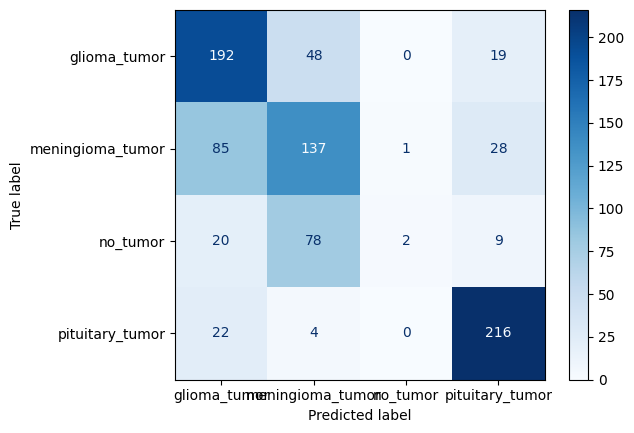

In [ ]:
def test_on_full_test_set(model, test_loader, device):
    model.eval()  # Coloca o modelo em modo de avaliação
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Desativa o cálculo do gradiente para economizar memória e tempo
        for inputs, labels in tqdm(test_loader, desc="Testing on Full Test Set"):
            inputs = inputs.to(device).view(-1, 128 * 128)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Obtém a classe com maior probabilidade

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcula as métricas
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=dataset_test.dataset.classes)
    cm = confusion_matrix(all_labels, all_preds)

    # print(f"Acurácia no conjunto de teste completo: {accuracy:.4f}")
    print("\nRelatório de Classificação no conjunto de teste completo:\n", report)
    ConfusionMatrixDisplay(cm, display_labels=dataset_test.dataset.classes).plot(cmap='Blues')

    model.train()  # Coloca o modelo de volta em modo de treinamento (boa prática)

# Supondo que você tenha seu modelo treinado chamado 'model' e seu train_loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_on_full_test_set(model, test_loader, device)


###Matriz de Confusão com os dados de treino

Testing on Full Train Set: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s]



Relatório de Classificação no conjunto de treinamento:
                   precision    recall  f1-score   support

    glioma_tumor       0.63      0.76      0.69       567
meningioma_tumor       0.53      0.57      0.55       571
        no_tumor       0.89      0.03      0.05       286
 pituitary_tumor       0.79      0.95      0.86       585

        accuracy                           0.66      2009
       macro avg       0.71      0.58      0.54      2009
    weighted avg       0.68      0.66      0.61      2009



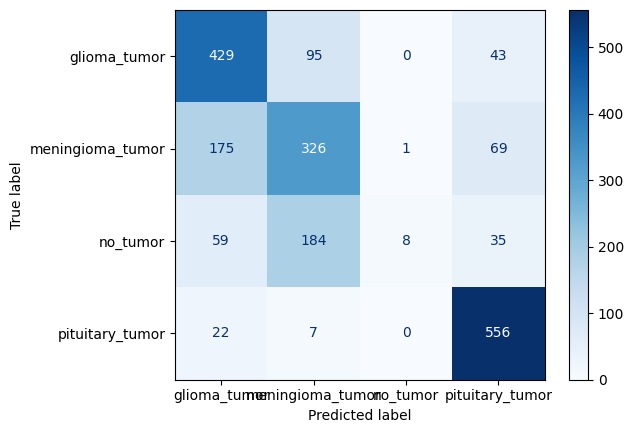

In [ ]:
def test_on_full_train_set(model, train_loader, device):
    model.eval()  # Coloca o modelo em modo de avaliação
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Desativa o cálculo do gradiente para economizar memória e tempo
        for inputs, labels in tqdm(train_loader, desc="Testing on Full Train Set"):
            inputs = inputs.to(device).view(-1, 128 * 128)  # Apenas necessário se for um modelo denso (MLP)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Obtém a classe com maior probabilidade

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcula as métricas
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=dataset_train.dataset.classes)
    cm = confusion_matrix(all_labels, all_preds)

    # print(f"Acurácia no conjunto de treinamento: {accuracy:.4f}")
    print("\nRelatório de Classificação no conjunto de treinamento:\n", report)

    ConfusionMatrixDisplay(cm, display_labels=dataset_train.dataset.classes).plot(cmap='Blues')


    model.train()  # Coloca o modelo de volta em modo de treinamento (boa prática)

# Supondo que você tenha seu modelo treinado chamado 'model' e seu train_loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_on_full_train_set(model, train_loader, device)

# Conclusão


Neste projeto, foi desenvolvida uma rede neural para realizar a classificação  de imagens de ressonância magnética do cérebro, com o objetivo de identificar a ausência ou presença de tumores cerebrais e seus tipos. O modelo foi treinado utilizando uma arquitetura simples de rede neural totalmente conectada (MLP), aplicando técnicas de pré-processamento de imagens e validação com divisão entre conjuntos de treino e teste.

Os resultados demonstraram que o modelo é capaz de aprender padrões nas imagens e obter uma acurácia razoável de classificação, conforme evidenciado pelas matrizes de confusão e relatórios de desempenho.
<br>

**Relatório de Classificação no conjunto de teste completo:**

                   precision    recall  f1-score   support

    glioma_tumor       0.60      0.74      0.66       259
    meningioma_tumor   0.51      0.55      0.53       251
    no_tumor           0.67      0.02      0.04       109
    pituitary_tumor    0.79      0.89      0.84       242

        accuracy                           0.64       861
       macro avg       0.64      0.55      0.52       861
    weighted avg       0.64      0.64      0.59       861




  **Relatório de Classificação no conjunto de treinamento:**

                     precision    recall  f1-score   support
    glioma_tumor       0.62      0.75      0.68       567
    meningioma_tumor   0.53      0.57      0.55       571
    no_tumor           0.89      0.03      0.05       286
    pituitary_tumor    0.79      0.95      0.86       585

        accuracy                           0.65      2009
       macro avg       0.71      0.57      0.54      2009
    weighted avg       0.68      0.65      0.61      2009


Com base nas demais Métricas (precisão, recall e F1-score) o modelo possui bom desempenho na classificação de imagens onde existe Tumor. Porém o modelo teve dificuldade em reconhecer e classificar imagens sem tumores (baixo valor de recall 0.03).

Próximos passos e oportunidades de melhoria seriam:

- Explorar arquiteturas mais complexas e adequadas para imagens, como redes convolucionais (CNNs);

- Utilizar Transfer Learning para reutilizar modelos já treinados em grandes bancos de dados em conjunto com o modelo original;

- Realizar validação cruzada para obter uma avaliação mais confiável;

- Considerando que a quantidade de imagens que não possuem tumor é menos da metade das existentes para cada uma das outras classes, seria interessante obter mais imagens desse tipo, ou gerar novas imagens a partir de transformações.


